## Setup

In [1]:
from scipy.io import loadmat

import scipy.stats as stats

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model

import mne

import numpy as np
import pandas as pd
import pandas_profiling

from matplotlib import pyplot as plt

from IPython import display as idisplay

import os
import re
from itertools import combinations

In [2]:
%matplotlib inline

## Config

In [3]:
PATHS = {
    'DATA_DIR': 'data/'
}

PATHS['TIME_DOMAIN_DATA_FILE'] = os.path.join(PATHS['DATA_DIR'], 'ID_25_epochsAll.set')
PATHS['DESIGN_MATRIX_FILE'] = os.path.join(PATHS['DATA_DIR'], 'ID_25_epochsAll_designMat.mat')

## Prepare Data

### 1. Design matrix

In [4]:
def load_design_matrix(path):
    mat = loadmat(path)
    columns = np.hstack(mat['epochs_allVars'].flat)
    df = pd.DataFrame(data=mat['epochs_all'], columns=columns)
    
    return df

In [5]:
df_design = load_design_matrix(PATHS['DESIGN_MATRIX_FILE'])

In [6]:
def cast_types(df, col_types):
    for col in col_types:
        df[col] = df[col].astype(col_types[col])
        
    return df

In [7]:
col_types = {
    'epochN': int,
    'artifactFlag': 'category',
    'binIndicator': 'category',
    'avg_reward': float,
    'reward': float,
    'iti': float,
    'trial_num': float,
    'run_num': float,
    'trial_in_run': float,
    'rt': float,
    'congruencyDC': 'category',
    'accDC': 'category',
    'previousCongruencyDC': 'category',
    'previousAcc': 'category',
    'trialType': 'category',
    'trialType': 'category',
    'keyRep': 'category',
    'cnvAmplitude': float
}

In [8]:
df_design = cast_types(df_design, col_types)

In [9]:
def convert_snake_case(s):
    result = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', s)
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', result).lower()

def clean_column_names(df, converter=convert_snake_case):
    df.columns = [converter(c) for c in df.columns]
    
    return df

In [10]:
df_design = clean_column_names(df_design)
# display(df_design)

#### 1a.) Study correlations between continuous variables (Pearson's R)

In [11]:
df_design_numeric = df_design.select_dtypes(include=[float, int]).dropna()
# pandas_profiling.ProfileReport(df_design_numeric)

#### 1b.) Study relationships between categorical variables (chi-square test of independence)

In [12]:
def get_chi2(df, c1, c2):
    contingency_table = [[sum((df[c1] == v1) & (df[c2] == v2)) for v1 in df[c1].unique()] for v2 in df[c2].unique()]

    return stats.chi2_contingency(contingency_table)

In [13]:
df_design_category = df_design.select_dtypes(include=['category']).dropna()

for c1, c2 in combinations(df_design_category.columns, 2):
    chi2, p, dof, f_exp = get_chi2(df_design_category, c1, c2)
    print("(%s, %s): %.2E %s" % (c1, c2, p, '**' if p < .05 else ''))

(artifact_flag, bin_indicator): 8.99E-01 
(artifact_flag, congruency_dc): 8.99E-01 
(artifact_flag, acc_dc): 4.68E-01 
(artifact_flag, previous_congruency_dc): 6.11E-01 
(artifact_flag, previous_acc): 8.44E-01 
(artifact_flag, trial_type): 8.89E-01 
(artifact_flag, key_rep): 3.77E-01 
(bin_indicator, congruency_dc): 3.66E-151 **
(bin_indicator, acc_dc): 9.43E-30 **
(bin_indicator, previous_congruency_dc): 4.93E-01 
(bin_indicator, previous_acc): 8.44E-01 
(bin_indicator, trial_type): 1.88E-149 **
(bin_indicator, key_rep): 4.46E-01 
(congruency_dc, acc_dc): 9.43E-30 **
(congruency_dc, previous_congruency_dc): 4.93E-01 
(congruency_dc, previous_acc): 8.44E-01 
(congruency_dc, trial_type): 1.88E-149 **
(congruency_dc, key_rep): 4.46E-01 
(acc_dc, previous_congruency_dc): 9.71E-01 
(acc_dc, previous_acc): 4.08E-01 
(acc_dc, trial_type): 2.05E-32 **
(acc_dc, key_rep): 3.57E-01 
(previous_congruency_dc, previous_acc): 7.30E-29 **
(previous_congruency_dc, trial_type): 1.88E-149 **
(previous_c

#### 1c.) Study categorical variable class distributions

In [14]:
# pandas_profiling.ProfileReport(df_design_category)

#### 1d.) One-way ANOVA

In [15]:
# TODO

### 2. Time-domain EEG data

In [18]:
def load_epochs(path=PATHS['TIME_DOMAIN_DATA_FILE'], verbose=False):
    epochs = mne.io.read_epochs_eeglab(path, verbose=verbose)
    
    return epochs

def get_single_epoch(epochs, epoch_index=0):
    df = pd.DataFrame(epochs[epoch_index].get_data()[0].T)
    df.columns = epochs.info['ch_names']
    
    return df

In [19]:
epochs = load_epochs()
df = get_single_epoch(epochs, epoch_index=0)
# pandas_profiling.ProfileReport(df)

At least one epoch has multiple events. Only the latency of the first event will be retained.


<ipython-input-18-5dd5a6aef91f>:2: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(path, verbose=verbose)


## Decode EEG data to columns in the design matrix

### Helper functions

In [22]:
def set_events(epochs, df_design, target, event_ids):
    epochs.events[:, 2] = df_design[target]
    epochs.event_id = event_ids
    
    return epochs

def drop(epochs, df_design, bools):
    epochs.drop(bools)
    df_design = df_design[[not b for b in bools]]
    
    return epochs, df_design

def drop_na(epochs, df_design):
    epochs.drop([any(x) for x in df_design.isnull().values])
    df_design = df_design.dropna()
    
    return epochs, df_design

def clean_epochs(epochs, df_design):
    epochs = epochs.crop(-.5, 1.)
    epochs = epochs.resample(100)
    epochs, df_design = drop(epochs, df_design, df_design['artifact_flag'] == 0)
    epochs, df_design = drop(epochs, df_design, df_design['acc_dc'] == 1)
    epochs, df_design = drop_na(epochs, df_design)
    
    return epochs, df_design

def get_classifier_training_data(epochs, df_design, target, event_ids):
    epochs = set_events(epochs, df_design, target, event_ids)
    epochs, df_design = clean_epochs(epochs, df_design)
    epochs, _ = epochs.equalize_event_counts(sorted(event_ids))
    
    X = epochs.get_data()
    y = epochs.events[:, 2]
    
    return X, y

def get_regressor_training_data(epochs, df_design, target):
    epochs, df_design = clean_epochs(epochs, df_design)
    
    X = epochs.get_data()
    y = df_design[target]
    
    return X, y

def decode(X, y, estimator, scoring, cv=4):
    pipeline = make_pipeline(StandardScaler(), estimator)
    slider = mne.decoding.SlidingEstimator(pipeline, scoring=scoring)
    cv_scores = mne.decoding.cross_val_multiscore(slider, X, y, cv=cv)
    mean_cv_scores = np.mean(cv_scores, axis=0)
    
    return mean_cv_scores

def plot_scores(times, scores, scoring, title, chance=.5, x_label='time (s)'):
    fig, ax = plt.subplots()
    
    ax.plot(times, scores)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(scoring)
    
    ax.axvline(.0, color='k', linestyle='-')
    if chance:
        ax.axhline(chance, color='k', linestyle='--', label='chance')
    
    ax.set_title(title)
    
    plt.show()

### 1. Decode congruency

At least one epoch has multiple events. Only the latency of the first event will be retained.


<ipython-input-18-5dd5a6aef91f>:2: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(path, verbose=verbose)


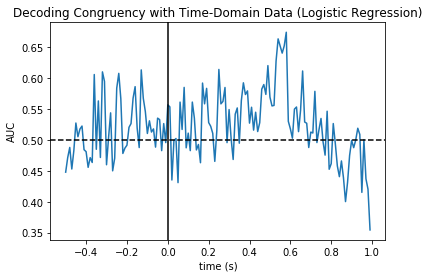

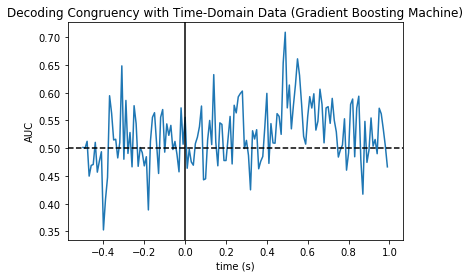

In [34]:
epochs = load_epochs()
X, y = get_classifier_training_data(epochs, df_design, 'congruency_dc', {'congruent': 0, 'incongruent': 1})

scores = decode(X, y, linear_model.LogisticRegression(), 'roc_auc', cv=4)
plot_scores(epochs.times, scores, 'AUC', 'Decoding Congruency with Time-Domain Data (Logistic Regression)')

scores = decode(X, y, ensemble.GradientBoostingClassifier(), 'roc_auc', cv=4)
plot_scores(epochs.times, scores, 'AUC', 'Decoding Congruency with Time-Domain Data (Gradient Boosting Machine)')

### 2. Decode reaction time

At least one epoch has multiple events. Only the latency of the first event will be retained.


<ipython-input-18-5dd5a6aef91f>:2: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(path, verbose=verbose)


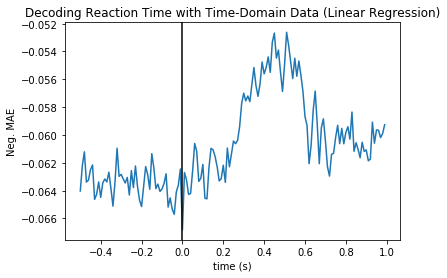

In [35]:
epochs = load_epochs()
X, y = get_regressor_training_data(epochs, df_design, 'rt')

scores = decode(X, y, linear_model.LinearRegression(), 'neg_mean_absolute_error', cv=4)
plot_scores(epochs.times, scores, 'Neg. MAE', 'Decoding Reaction Time with Time-Domain Data (Linear Regression)', chance=None)

### 3. Decode average reward

At least one epoch has multiple events. Only the latency of the first event will be retained.


<ipython-input-18-5dd5a6aef91f>:2: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(path, verbose=verbose)


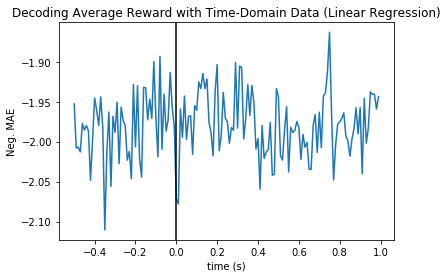

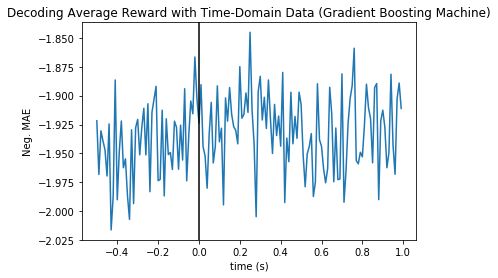

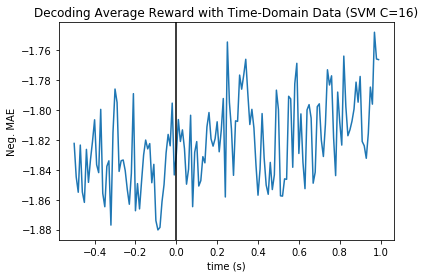

In [36]:
epochs = load_epochs()
X, y = get_regressor_training_data(epochs, df_design, 'avg_reward')

scores = decode(X, y, linear_model.LinearRegression(), scoring='neg_mean_absolute_error', cv=4)
plot_scores(epochs.times, scores, 'Neg. MAE', 'Decoding Average Reward with Time-Domain Data (Linear Regression)', chance=None)

scores = decode(X, y, ensemble.GradientBoostingRegressor(), scoring='neg_mean_absolute_error', cv=4)
plot_scores(epochs.times, scores, 'Neg. MAE', 'Decoding Average Reward with Time-Domain Data (Gradient Boosting Machine)', chance=None)

scores = decode(X, y, svm.SVR(), scoring='neg_mean_absolute_error', cv=4)
plot_scores(epochs.times, scores, 'Neg. MAE', 'Decoding Average Reward with Time-Domain Data (SVM C=%d)' % c, chance=None)